In [ ]:
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np

In [ ]:
def color_dataset(dataset, colors, random = True):
    colored_dataset = []
    for i, (img, label) in enumerate(dataset):
        if random:
            color = colors[random.randint(0, len(colors)-1)]
        else:
            color = colors[label]
        colored_img = torch.zeros((3, img.shape[1], img.shape[2]))
        for j in range(3):
            colored_img[j] = img[0] * (color[j]/255)
        colored_dataset.append((colored_img, label))
    return colored_dataset

def display_mnist(dataloader, mod):
    images, labels = next(iter(dataloader))
    disp_imgs = []
    for i in range(10):
        pic_idx = 0
        while labels[pic_idx] != i:
            pic_idx += 1
        disp_imgs.append(images[pic_idx])
    display_images_in_grid(disp_imgs, 4, 3, f'mnist_{mod}.png')

def display_images_in_grid(imgs, grid_height = 2, grid_width = 3, path = None):
    fig = plt.figure(figsize=(10, 10))
    for i in range(1, len(imgs) + 1):
        img = imgs[i-1].to('cpu').detach().numpy().astype(dtype=np.float64)
        ax = fig.add_subplot(grid_height, grid_width, i)
        ax.imshow(np.transpose(img, (1, 2, 0)))
    plt.savefig(path) if path is not None else plt.show()
    plt.clf()

def color_mnist(BATCH_SIZE, colors, mod):
    # MNIST Dataset
    train_dataset = dsets.MNIST(root='./data', train=True,transform=transforms.ToTensor(),download=True)

    test_dataset = dsets.MNIST(root='./data', train=False,transform=transforms.ToTensor(),download=True)

    dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])

    colored_dataset = color_dataset(dataset, colors, mod == 'random')

    dataloader = torch.utils.data.DataLoader(dataset=colored_dataset, batch_size=BATCH_SIZE,shuffle=True)

    return dataloader

# plot results of lists
def plot_lists(lists, labels, title, x_label, y_label, save_path=None, accuracy = True, epochs=None):
    if type(lists[0]) != list:
        lists = [lists]
        labels = [labels]
    if len(lists) != len(labels):
        raise ValueError('Lists and labels must have the same length')
    n = len(lists[0])
    if epochs is None:
        epochs = np.arange(1,n+1)
    for lab, lis in zip(labels, lists):
        plt.plot(epochs, lis, label = lab)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if accuracy:
        plt.locator_params(nbins=10, axis='y')
        plt.ylim(0.1)
    plt.legend()
    if n < 15:
        plt.locator_params(nbins=n, axis='x')
    if save_path is not None:
        print(f'Saving plot to {save_path}')
        plt.savefig(save_path)
    else:
        plt.show()

In [ ]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.conv = nn.Sequential(nn.Conv2d( in_channels,out_channels,4,stride,1,bias=True,padding_mode="reflect"),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True))

    def forward(self, x):
        return self.conv(x)

class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels, features[0], kernel_size=4, stride=2, padding=1, padding_mode="reflect",),
            nn.LeakyReLU(0.2, inplace=True))
        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(Block(in_channels, feature, stride=1 if feature == features[-1] else 2))
            in_channels = feature
        layers.append(nn.Conv2d(in_channels,1,kernel_size=4,stride=1,padding=1,padding_mode="reflect"))
        self.model = nn.Sequential(*layers)
    def forward(self, x):
        x = self.initial(x)
        return torch.sigmoid(self.model(x))

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **kwargs)
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True) if use_act else nn.Identity())

    def forward(self, x):
        return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size=3, padding=1),
            ConvBlock(channels, channels, use_act=False, kernel_size=3, padding=1))

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, img_channels=3, num_features=64, num_residuals=9):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(img_channels,num_features,kernel_size=7,stride=1,padding=3,padding_mode="reflect"),
            nn.InstanceNorm2d(num_features),
            nn.ReLU(inplace=True))
        self.down_blocks = nn.ModuleList(
            [ConvBlock(num_features, num_features * 2, kernel_size=3, stride=2, padding=1),
                ConvBlock(num_features * 2,num_features * 4,kernel_size=3,stride=2,padding=1)])
        self.res_blocks = nn.Sequential(*[ResidualBlock(num_features * 4) for _ in range(num_residuals)])
        self.up_blocks = nn.ModuleList([
                ConvBlock(num_features * 4,num_features * 2,down=False,kernel_size=3,stride=2,padding=1,output_padding=1),
                ConvBlock(num_features * 2,num_features * 1,down=False,kernel_size=3,stride=2,padding=1,output_padding=1)])

        self.last = nn.Conv2d(num_features * 1,img_channels,kernel_size=7,stride=1,padding=3,padding_mode="reflect",)

    def forward(self, x):
        x = self.initial(x)
        for layer in self.down_blocks:
            x = layer(x)
        x = self.res_blocks(x)
        for layer in self.up_blocks:
            x = layer(x)
        return torch.sigmoid(self.last(x))

In [ ]:

def to_cuda(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return x

def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

In [ ]:
mse = nn.MSELoss()

def discriminator_loss(real_output, fake_output):
    real_loss = mse(real_output, torch.zeros_like(real_output))
    fake_loss = mse(fake_output, torch.ones_like(fake_output))
    total_loss = (real_loss + fake_loss)/2
    return total_loss

def generator_loss(fake_output):
    return mse(fake_output, torch.ones_like(fake_output))


In [ ]:
class cycleGAN(nn.Module):
    def __init__(self, num_features = 64, num_residuals = 9, disc_features = [64, 128, 256, 512]):
        super(cycleGAN, self).__init__()
        self.model_name = 'cycleGAN'
        self.losses = []
        print(f'number of features: {num_features}, number of residuals: {num_residuals}')
        # Discriminator A to B
        self.D_A = Discriminator(features=disc_features)

        # Generator A to B
        self.G_A_to_B = Generator(num_features = num_features, num_residuals=num_residuals)

        # Discriminator B to A
        self.D_B = Discriminator(features=disc_features)

        # Generator B to A
        self.G_B_to_A = Generator(num_features = num_features, num_residuals=num_residuals)

        print(f'{self.model_name} initialized, number of parameters: {self.count_parameters()}')

    def train(self, train_loader1, train_loader2, max_epochs = 100, eps = None, learning_rate = 0.01):
        learning_rate = 0.0005
        g_optimizer = torch.optim.Adam(list(self.G_A_to_B.parameters()) + list(self.G_B_to_A.parameters()), lr=learning_rate)
        d_optimizer = torch.optim.Adam(list(self.D_A.parameters()) + list(self.D_B.parameters()), lr=learning_rate)

        self.losses = []
        mse = nn.MSELoss()
        l1 = nn.L1Loss()
        print(f'Training the {self.model_name} model...')
        print('_'*50)
        for epoch in range(max_epochs):
            train_total_loss = 0
            for i, ((im1, _), (im2, _)) in enumerate(tqdm(zip(train_loader1, train_loader2))):

                fake_B = self.G_A_to_B(im1)
                fake_A = self.G_B_to_A(im2)
                cycle_A = self.G_B_to_A(fake_B)
                cycle_B = self.G_A_to_B(fake_A)

                dreal_A = self.D_A(im1) # Real images
                dreal_B = self.D_B(im2) # Real images
                dfake_A = self.D_A(fake_A) # generated images
                dfake_B = self.D_B(fake_B) # generated images

                disc_loss_B = discriminator_loss(dreal_B, dfake_B)
                disc_loss_A = discriminator_loss(dreal_A, dfake_A)
                disc_loss = (disc_loss_A + disc_loss_B)/2

                gen_loss_B = generator_loss(fake_B)
                gen_loss_A = generator_loss(fake_A)
                cycle_loss = l1(cycle_A, im1) + l1(cycle_B, im2)

                gen_loss = gen_loss_A + gen_loss_B + cycle_loss

                # Backprop + Optimize
                g_optimizer.zero_grad()
                gen_loss.backward()
                g_optimizer.step()

               # Backprop + Optimize
                d_optimizer.zero_grad()
                disc_loss.backward()
                d_optimizer.step()

                loss = disc_loss + gen_loss
                train_total_loss += loss.item()

                print(f"d loss :{disc_loss.item()} g loss : {gen_loss.item(), gen_loss_A.item(), cycle_loss.item()}")
                if (i+1) % 50 == 0:
                    tqdm.write('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                        .format(epoch+1, max_epochs, (i+1) , len(train_loader1), loss.item()))
                    sub_images = [im1[0], fake_A[0], cycle_A[0], im2[0], fake_B[0], cycle_B[0]]
                    display_images_in_grid(sub_images, 2, 3, f'curr_epoch{i}_display.png')
            self.losses.append(train_total_loss / len(train_loader1))
            print(f'Average Loss at Epoch {epoch + 1} is {round(self.losses[-1],3)}')
            print('_'*50)
            if epoch > 0 and eps is not None and abs(self.losses[-1] - self.losses[-2]) < eps:
                print('Early stopping')
                break
        print(f'Finished training the {self.model_name} model')

    def save_image(image, path):
        plt.imshow(np.transpose(image.to('cpu'), (1, 2, 0)))
        plt.savefig(path)

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def plot(self):
        plot_lists(self.losses, 'Loss', f'{self.model_name} Loss', 'Epoch', 'Loss', f'{self.model_name}_loss.png', accuracy = False)

    def save(self, path):
        torch.save(self.state_dict(), path)
        torch.save(self.losses, f'{path}_losses.pkl')


In [ ]:
import torch
batch_size = 128
colors1 = ((187, 45, 226), (183, 88, 11), (221, 215, 26), (29, 139, 186), (229, 39, 54), (24, 163, 107), (119, 221, 59), (211, 23, 145), (22, 20, 155), (109, 2, 204))
colors2 = ((198, 99, 77), (185, 95, 244), (22, 20, 155), (201, 30, 167), (159, 244, 90), (86, 89, 191), (242, 89, 137), (34, 193, 66), (96, 255, 183), (232, 213, 46))
mod1 = 'const_1'
mod2 = 'const_2'

print(f'Loading MNIST dataset...')
MNIST1 = color_mnist(batch_size, colors1, mod1)
MNIST2 = color_mnist(batch_size, colors2, mod2)

display_mnist(MNIST1, mod1)
display_mnist(MNIST2, mod2)

In [ ]:
model = cycleGAN(num_features = 14, num_residuals = 3, disc_features=[64, 128, 256])
model.train(MNIST1, MNIST2, eps=1e-04, max_epochs=5)
model.save('cycleGAN.pkl')
model.plot()

In [ ]:
with torch.no_grad():
  for i, ((im1, _), (im2, _)) in enumerate(tqdm(zip(MNIST1, MNIST2), initial=1)):
    fake_B = model.G_A_to_B(im1)
    fake_A = model.G_B_to_A(im2)
    cycle_A = model.G_B_to_A(fake_B)
    cycle_B = model.G_A_to_B(fake_A)
    sub_images = [im1[0], cycle_A[0], im2[0], cycle_B[0]]
    display_images_in_grid(sub_images, 2, 3, 'test.png')
    break

All 3 results:

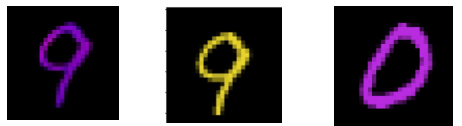